### QUESTION 3

In the first two questions, you were expected to design a new network, train it, and obtain an feature vector for each image based on the weights of the trained network. In this question, you are expected to download the weights of the trained VGG-16 network with the built-in functions of Keras in the Imagenet contest and to get the closest images for the images in your test set using the weights in the first fully-connected layer of the VGG-16 network. 

In [1]:
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from functions import get_num_files
from functions import get_num_subfolders
from functions import create_img_generator_for_VGG16
from functions import plot_accuracy
from functions import plot_loss

Using TensorFlow backend.


In [2]:
# Suppress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='2'

In [3]:
# Main code
image_width, image_height=256, 256
Training_Epochs=50
Batch_Size=32
Number_FC_Neurons=512

In [4]:
# dataset/
#   train/
#       category1/(contains all images related to category1)  
#       category2/(contains all images related to category2)
#       ...
#       ...       
# 
#   validation/
#       category1/(contains all images related to category1)  
#       category2/(contains all images related to category2)
#       ...
#       ...
#       
#   test/
#       category1/(contains all images related to category1)  
#       category2/(contains all images related to category2)
#       ...
#       ...

In [5]:
train_dir = './dataset/train'
validate_dir = './dataset/validation'
test_dir = './dataset/test'

In [6]:
num_epoch = Training_Epochs
batch_size = Batch_Size

num_classes = get_num_subfolders(train_dir)

num_train_samples = get_num_files(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_test_samples = get_num_files(test_dir)

In [7]:
# Defining image generators for training and testing
train_image_gen = create_img_generator_for_VGG16()
validation_image_gen = create_img_generator_for_VGG16()

In [8]:
# Training image generator
train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_width),
    batch_size=batch_size,
    seed=42 # set seed for reproducability
    )

# Validation image generator
validation_generator = validation_image_gen.flow_from_directory(
    validate_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    seed=42 # set seed for reproducability
    )

# Test image generator
test_generator = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    seed=42 # set seed for reproducability
    )

Found 4075 images belonging to 17 classes.
Found 494 images belonging to 17 classes.
Found 494 images belonging to 17 classes.


In [9]:
# Load the VGG16 model and load it with it's pre-trained weights.
VGG16_base_model = VGG16(weights='imagenet', include_top=False) #include_top=False excludes final FC layer

print('VGG16 base model without last FC loaded')
print(VGG16_base_model.summary())

VGG16 base model without last FC loaded
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooli

In [10]:
# Freeze all layers
for layer in VGG16_base_model.layers:
    layer.trainable=False

print(VGG16_base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
# Define the layers in the new classification prediction
x = VGG16_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x)      # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x) # new softmax layer

In [12]:
# Define trainable model which links input 
# from the VGG16 base model to the new classification prediction layer
model = Model(inputs=VGG16_base_model.input, outputs=predictions)

In [13]:
# print model structure diagram
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [14]:
# Transfer Learning
print("\nPerforming Transfer Learning")

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    


Performing Transfer Learning


In [15]:
# Fit the Transfer Learning model to the data from the generators
history = model.fit_generator(
    train_generator,
    epochs=num_epoch,
    steps_per_epoch=num_train_samples//batch_size,
    validation_data=validation_generator,
    validation_steps=num_validate_samples//batch_size,
    class_weight='auto',
    shuffle=True)

Epoch 1/50
127/127 [==============================] - 107s 841ms/step - loss: 2.7586 - accuracy: 0.3119 - val_loss: 2.0946 - val_accuracy: 0.3625
Epoch 2/50
127/127 [==============================] - 99s 779ms/step - loss: 1.8464 - accuracy: 0.4291 - val_loss: 2.2957 - val_accuracy: 0.3701
Epoch 3/50
127/127 [==============================] - 97s 766ms/step - loss: 1.6504 - accuracy: 0.4868 - val_loss: 1.6267 - val_accuracy: 0.4307
Epoch 4/50
127/127 [==============================] - 92s 727ms/step - loss: 1.4848 - accuracy: 0.5251 - val_loss: 1.8995 - val_accuracy: 0.4113
Epoch 5/50
127/127 [==============================] - 92s 726ms/step - loss: 1.3568 - accuracy: 0.5620 - val_loss: 1.9158 - val_accuracy: 0.4329
Epoch 6/50
127/127 [==============================] - 93s 735ms/step - loss: 1.2516 - accuracy: 0.5889 - val_loss: 1.7625 - val_accuracy: 0.4610
Epoch 7/50
127/127 [==============================] - 90s 708ms/step - loss: 1.1645 - accuracy: 0.6154 - val_loss: 1.8347 - val_a

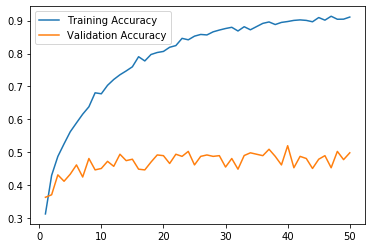

0

In [16]:
# Plot training and validation accuracy
plot_accuracy(history)

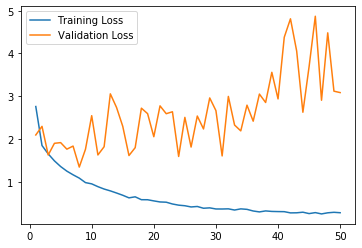

0

In [17]:
# Plot training and validation loss
plot_loss(history)

In [18]:
# Print test set accuracy and loss values
scores = model.evaluate_generator(test_generator, num_test_samples/batch_size)
print("loss: {}, accuracy: {}".format(scores[0], scores[1]))

loss: 6.883925437927246, accuracy: 0.42105263471603394
